In [1]:
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed, Flatten
from tensorflow.keras.layers import LSTM, GRU, RNN
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import data into a dataframe
data = np.load('polution_dataSet.npy')

In [3]:
'''
IN this part data for test, validation and train is preperd.
'''
# data format is : pollution  ,dew  ,temp  , press ,wnd_dir , wnd_spd , snow , rain
# total data =43000
# per day and week = 43000/24*7 =250

SAMPLE_DISTANCE = 24*7    # if 1 sample per hour, if 24 per day, if 24*7 per week
TRAIN_SIZE = 120
VAL_SIZE = 50
TEST_SIZE = 30
TIMESTEPS = 8             # timesteps used for a single prediction (here each timestep is a week)
HOUR = 2                  # which hour of day ? (0-23) (not so important)

In [4]:
x_train = []
y_train = []
for i in range(TRAIN_SIZE):
    x_train.append(np.array(data[i*SAMPLE_DISTANCE+HOUR:i*SAMPLE_DISTANCE+TIMESTEPS+HOUR]))
    y_train.append(np.array(data[i*SAMPLE_DISTANCE+TIMESTEPS+HOUR, 0]))
x_train = np.array(x_train)
y_train = np.array(y_train)

In [5]:
x_val = []
y_val = []
for i in range(TRAIN_SIZE, TRAIN_SIZE+VAL_SIZE):
    x_val.append(np.array(data[i*SAMPLE_DISTANCE+HOUR:i*SAMPLE_DISTANCE+TIMESTEPS+HOUR]))
    y_val.append(np.array(data[i*SAMPLE_DISTANCE+TIMESTEPS+HOUR, 0]))
x_val = np.array(x_val)
y_val = np.array(y_val)

In [6]:
x_test = []
y_test = []
for i in range(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE):
    x_test.append(np.array(data[i*SAMPLE_DISTANCE+HOUR:i*SAMPLE_DISTANCE+TIMESTEPS+HOUR]))
    y_test.append(np.array(data[i*SAMPLE_DISTANCE+TIMESTEPS+HOUR, 0]))
x_test = np.array(x_test)
y_test = np.array(y_test)
y_total = np.concatenate([y_train, y_val, y_test], axis=None)

In [7]:
'''
In this part network is implemented 
'''
# parameters
BATCH_SIZE = 10
NUM_EPOCHS = 20
HIDDEN_SIZE = 40

In [8]:
# class for RNN Keras
class MinimalRNNCell(keras.layers.Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(MinimalRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='uniform',
            name='recurrent_kernel')
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        h = K.dot(inputs, self.kernel)
        output = h + K.dot(prev_output, self.recurrent_kernel)
        return output, [output]

In [9]:
# Let's use this cell in a RNN layer:
cell = MinimalRNNCell(HIDDEN_SIZE)

In [10]:
K.clear_session()
# keras modeling
model = Sequential()
model.add(RNN(cell, input_shape=(TIMESTEPS, 8), return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, 40)                1920      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, verbose=1, validation_data=(x_val, y_val))

Train on 120 samples, validate on 50 samples
Epoch 1/20
120/120 [==============================] - 1s 9ms/step - loss: 0.0778 - val_loss: 0.0569
Epoch 2/20
120/120 [==============================] - 0s 225us/step - loss: 0.0540 - val_loss: 0.0634
Epoch 3/20
120/120 [==============================] - 0s 242us/step - loss: 0.0480 - val_loss: 0.0498
Epoch 4/20
120/120 [==============================] - 0s 242us/step - loss: 0.0408 - val_loss: 0.0394
Epoch 5/20
120/120 [==============================] - 0s 225us/step - loss: 0.0364 - val_loss: 0.0322
Epoch 6/20
120/120 [==============================] - 0s 233us/step - loss: 0.0253 - val_loss: 0.0228
Epoch 7/20
120/120 [==============================] - 0s 225us/step - loss: 0.0217 - val_loss: 0.0255
Epoch 8/20
120/120 [==============================] - 0s 259us/step - loss: 0.0207 - val_loss: 0.0191
Epoch 9/20
120/120 [==============================] - 0s 250us/step - loss: 0.0164 - val_loss: 0.0203
Epoch 10/20
120/120 [==================

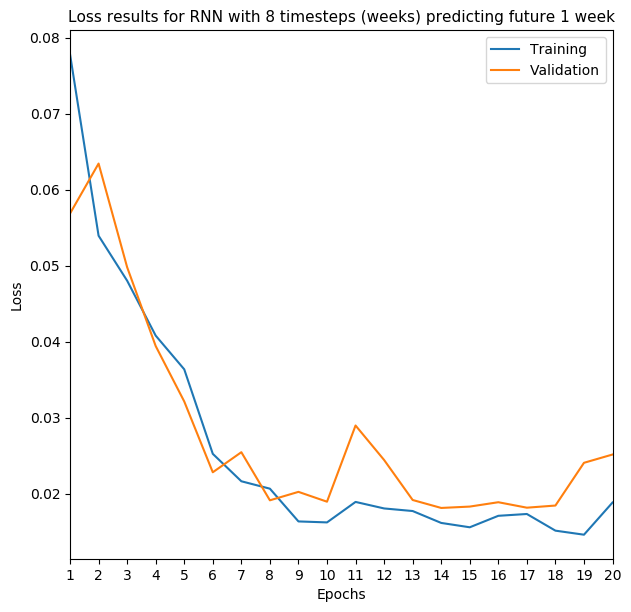

In [13]:
plt.figure(1, figsize=(7, 7), dpi=100)
plt.style.use(['default'])
plt.plot(np.arange(1,NUM_EPOCHS+1,1), history.history['loss'], label='Training')
plt.plot(np.arange(1,NUM_EPOCHS+1,1), history.history['val_loss'], label='Validation')
plt.xticks(np.arange(1, NUM_EPOCHS+1, 1, dtype=int))
plt.xlim(1, NUM_EPOCHS)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss results for RNN with 8 timesteps (weeks) predicting future 1 week', fontsize=11)
plt.legend()
plt.show()

In [14]:
print('train loss history:', history.history["loss"])
print('test loss history:', history.history["val_loss"])
scores = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1)
print('\nTest result loss: %.3f' % (scores))

train loss history: [0.07782309626539548, 0.05395319778472185, 0.04803706146776676, 0.040811340945462384, 0.03637755817423264, 0.02526088027904431, 0.021653853667279083, 0.02067854139022529, 0.01637025720750292, 0.01624194416217506, 0.01893688637452821, 0.018078115691120427, 0.017738372591945033, 0.01617177956116696, 0.015600147346655527, 0.017109747355182964, 0.017348208154241245, 0.015156548703089356, 0.014624716403583685, 0.018858013829837244]
test loss history: [0.05686983540654182, 0.06344340369105339, 0.049810586124658586, 0.03944116979837418, 0.03215142339468002, 0.022835581190884115, 0.025476405397057533, 0.019148122146725656, 0.020259123668074606, 0.018966202065348624, 0.028987917304039, 0.024452509358525276, 0.019190208055078983, 0.018143417686223982, 0.018322799541056155, 0.018897119909524918, 0.018178080022335053, 0.018459651339799165, 0.024081902019679545, 0.02517167590558529]
30/30 [==============================] - 0s 167us/step

Test result loss: 0.018


In [15]:
y_train = model.predict(x_train, batch_size=BATCH_SIZE)
y_val = model.predict(x_val, batch_size=BATCH_SIZE)
y_pred = model.predict(x_test, batch_size=BATCH_SIZE)

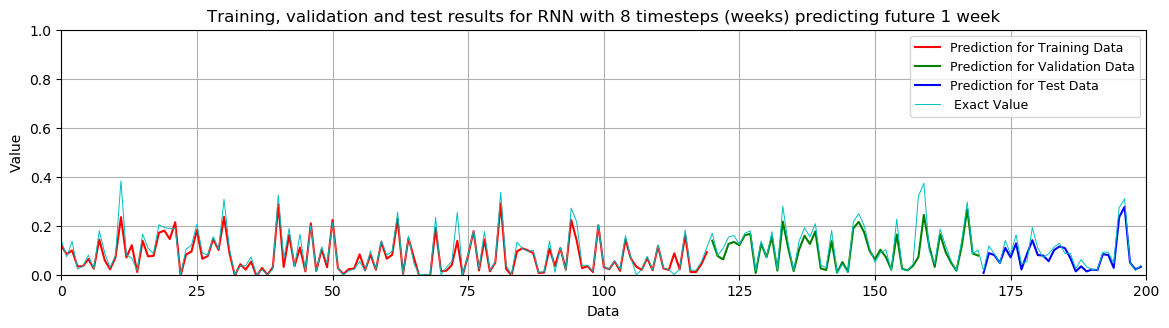

In [16]:
plt.figure(2, figsize=(14, 7), dpi=100)
plt.style.use(['default'])
plt.subplot(211)
plt.plot(range(0, TRAIN_SIZE), y_train, c='r', linewidth=1.5, label='Prediction for Training Data')
plt.plot(range(TRAIN_SIZE, TRAIN_SIZE+VAL_SIZE), y_val, c='g', linewidth=1.5, label='Prediction for Validation Data')
plt.plot(range(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE), y_pred, c='b', linewidth=1.5, label='Prediction for Test Data')
plt.plot(range(0, TRAIN_SIZE+VAL_SIZE+TEST_SIZE), y_total, c='c', linewidth=0.7, label=' Exact Value')
plt.xlim(0, TRAIN_SIZE+VAL_SIZE+TEST_SIZE)
plt.ylim(0, 1)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Training, validation and test results for RNN with 8 timesteps (weeks) predicting future 1 week')
plt.legend(loc='best', fontsize=9)
plt.grid(True)
plt.show()

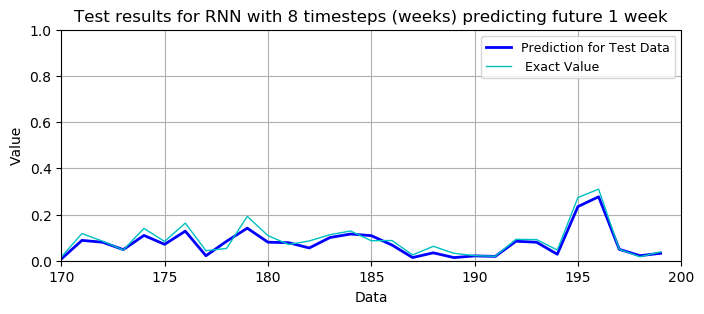

In [17]:
plt.figure(3, figsize=(8, 3), dpi=100)
plt.style.use(['default'])
plt.plot(range(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE), y_pred, 'b', linewidth=2, label='Prediction for Test Data')
plt.plot(range(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE), y_total[TRAIN_SIZE+VAL_SIZE:TRAIN_SIZE+VAL_SIZE+TEST_SIZE], c='c', linewidth=1, label=' Exact Value')
plt.xlim(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE)
plt.ylim(0, 1)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Test results for RNN with 8 timesteps (weeks) predicting future 1 week')
plt.grid(True)
plt.legend(loc='best', fontsize=9)
plt.show()